In [12]:
from pycaret.datasets import get_data
from pycaret.classification import *
import pandas as pd
import mlflow
import shap
from sklearn.decomposition import PCA
import pacmap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from datetime import datetime
import prince

In [3]:
#Setup

file = r'C:\Users\atrip\Research\Model-Interpretation-main\Data\ml_labelled_modified_HN_P2C_20241212.csv'
df = pd.read_csv(file)
print(list(df.columns))



['SubjectID', 'IRB', 'Instrument', 'PrimaryAnatomy', 'Patient_LevelInclude_Exclude', 'Setup', 'Age', 'Sex', 'Ethnicity', 'Race', 'HighestDiagnosisLevel', 'HPVStatus', 'TobaccoUse', 'SmokelessTobaccoUse', 'AlcoholUse', 'OccultPrimaryTumor', 'TumorFocality', 'GrossTumorSize_GreatestDimensionInCentimeters_', 'TumorDepthOfInvasion_DOI__mm_', 'Margins_DistanceFromClosestMargin_mm_', 'StandardUptakeValue_SUV_FromPET_CT', 'NumberOfLymphNodesExamined', 'NumberOfInvolvedLymphNodes', 'SizeOfLargestMetastaticDeposit_cm_', 'LateralityOfLymphNodesInvolved', 'PrimaryTumor_pT_', 'RegionalLymphNodes_pN_', 'TNMDescriptors', 'Chemo_RadiationTherapy', 'AfterSurgery', 'Recurrence', 'Local_days_', 'Regional_days_', 'Distant_days_', 'Death_days_', 'Surgeon', 'Comments_', 'x1', 'Run', 'ScanContext', 'DataChannelsUsed', 'indices_1', 'lifet_avg_ch1', 'lifet_avg_ch2', 'lifet_avg_ch3', 'spec_int_ch1', 'spec_int_ch2', 'spec_int_ch3', 'int_ratio_ch1', 'int_ratio_ch2', 'int_ratio_ch3', 'Laguerre_coeffs_ch1_1', 'Lag

In [5]:
#number of patients in study
print(len(df['SubjectID'].unique()))

98


In [23]:
# #filters out any cases with less than 100 datapoints
# case_counts = df['Case'].value_counts()
# filtered_cases = case_counts[case_counts > 100].index
# filtered_df = df[df['Case'].isin(filtered_cases)]

# df = df[df['ML_label'] != 'Ignore']

selected_columns = ['Tob_label', 'Alc_label', 'HPVStatus', 'ML_label']
data = df[selected_columns]

print(data)


        Tob_label    Alc_label HPVStatus ML_label
0          Former  Not Current  Positive  Healthy
1          Former  Not Current  Positive  Healthy
2          Former  Not Current  Positive  Healthy
3          Former  Not Current  Positive  Healthy
4          Former  Not Current  Positive  Healthy
...           ...          ...       ...      ...
2200009     Never          Yes  Positive   Ignore
2200010     Never          Yes  Positive   Ignore
2200011     Never          Yes  Positive   Ignore
2200012     Never          Yes  Positive   Ignore
2200013     Never          Yes  Positive   Ignore

[2200014 rows x 4 columns]


Finished with encoding and SMOTE balancing


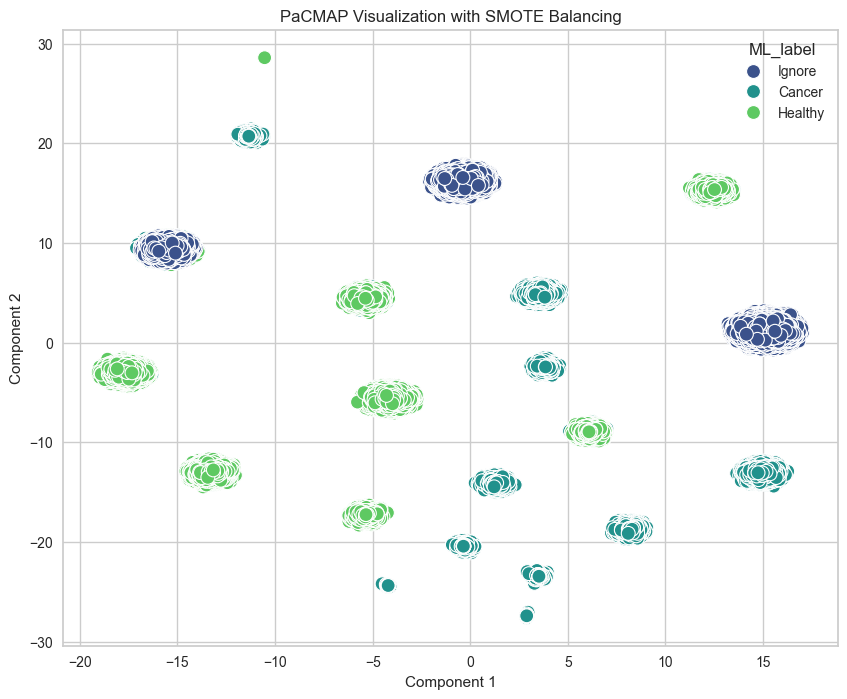

In [24]:
# Split the data into features and target
X = data[['Tob_label', 'Alc_label', 'HPVStatus']]
y = data['ML_label']

# One-Hot Encode the categorical variables
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert the resampled data back to DataFrame for easier manipulation
X_resampled_df = pd.DataFrame(X_resampled, columns=encoder.get_feature_names_out(['Tob_label', 'Alc_label', 'HPVStatus']))
X_resampled_df['ML_label'] = y_resampled

# Apply PaCMAP to the resampled features
n_components = 2  # Change this to experiment with different numbers of components
reducer = pacmap.PaCMAP(n_components=n_components, random_state=42)
X_reduced = reducer.fit_transform(X_resampled_df.drop('ML_label', axis=1))

# Convert the reduced data to a DataFrame
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'Component {i+1}' for i in range(X_reduced.shape[1])])
X_reduced_df['ML_label'] = X_resampled_df['ML_label']

print("Finished with encoding and SMOTE balancing")

# Get the current date
current_date = datetime.now().strftime('%Y-%m-%d')

# Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='ML_label', data=X_reduced_df, palette='viridis', s=100)
plt.title('PaCMAP Visualization with SMOTE Balancing')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='ML_label')
plt.savefig(f'pacmap_visualization_with_smote_balancing_{current_date}.png')  # Save the plot to a file with the current date
plt.show()

finished w encoding


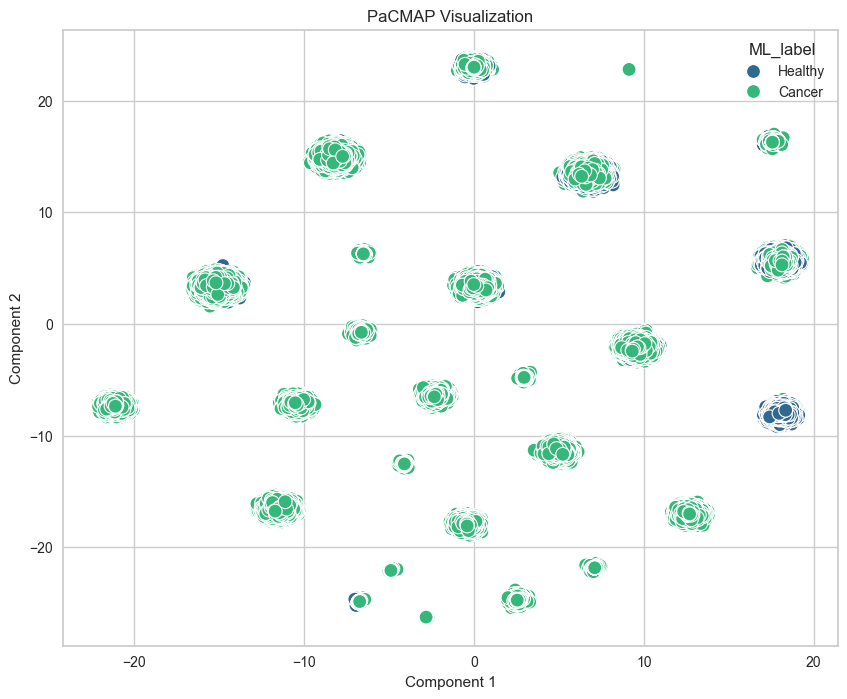

In [4]:
#PACMAP Encoding and Visualization


encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(data[['Tob_label', 'Alc_label', 'HPVStatus']])


encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Tob_label', 'Alc_label', 'HPVStatus']))

n_components = 2  # Change this to experiment with different numbers of components

# Initialize PaCMAP
reducer = pacmap.PaCMAP(n_components=n_components, random_state=42)

# Apply PaCMAP to the features (excluding the target column)
X_reduced = reducer.fit_transform(encoded_features_df)

# Convert the reduced data to a DataFrame
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'Component {i+1}' for i in range(X_reduced.shape[1])])

# Add the target variable back to the reduced DataFrame
X_reduced_df['ML_label'] = data['ML_label']


print("finished w encoding")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='ML_label', data=X_reduced_df, palette='viridis', s=100)
plt.title('PaCMAP Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='ML_label')
plt.savefig('pacmap_visualization_without_balancing.png')  # Save the plot to a file
plt.show()

In [13]:
#MCA Visualization. MCA is similar to PCA yet it is better suited for categorical variables.
# Initialize MCA
mca = prince.MCA(n_components=2, random_state=42)

# Fit MCA to the data (excluding the target column)
mca_result = mca.fit_transform(data[['Tob_label', 'Alc_label', 'HPVstatus']])

# Convert the MCA results to a DataFrame
mca_df = pd.DataFrame(mca_result, columns=[f'Component {i+1}' for i in range(mca_result.shape[1])])

# Add the target variable back to the reduced DataFrame
mca_df['ML_label'] = data['ML_label']

# Plotting the reduced features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='ML_label', data=mca_df, palette='viridis', s=100)
plt.title('MCA Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='ML_label')
plt.savefig('mca_visualization.png')  # Save the plot to a file
plt.show()

NameError: name 'data' is not defined

In [ ]:
run = setup(data, target = 'ML_label', pca= True, pca_components = None, experiment_name= 'FeatCorrelation', fix_imbalance=True, use_gpu=True)
#normalize = True to normalize data

In [ ]:
#model training, picks up best 3

best_model = compare_models(sort = 'Accuracy', n_select=3)

In [ ]:
print(best_model[1])

In [ ]:
tuned_dts = []
for model in best_model:
    tuned_dts.append(tune_model(model))

In [ ]:
plot_model(best_model[0], plot = 'auc')


In [ ]:
print(best_model[0])

In [ ]:
import pycaret.classification

knn = best_model[0]


# Get the transformed training and test data
X_train_transformed = pycaret.classification.get_config('X_train_transformed')
X_test_transformed = pycaret.classification.get_config('X_test_transformed')

# Optional: Reduce the size of the background set for KernelExplainer
background = shap.sample(X_train_transformed, 1)

# Create a SHAP KernelExplainer
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_transformed)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_transformed)


In [ ]:
loaded_model = load_model('KClassifierBest')
print(loaded_model)

In [ ]:


clf = setup(data, target = 'ML_label')
plot_model(loaded_model, plot = 'auc')